In [1]:
#Data import

import pandas as pd
import numpy as np
import math
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

COMPLETE_df = pd.read_csv("Stock Data (2012-2022)/COMPLETE_data.csv", index_col = 0, parse_dates = True).dropna()

SPY_df = pd.read_csv("Stock Data (2012-2022)/SPY_data.csv", index_col = 0, parse_dates = True).dropna()

In [2]:
#Create the training and testing datas sets

TRAINING_df = COMPLETE_df.loc['2012-01-01':'2016-12-31']
PRECOVID_TESTING_df = COMPLETE_df.loc['2017-01-01':'2019-12-31']
COVID_TESTING_df = COMPLETE_df.loc['2020-01-01':'2022-01-01']

TRAINING_MARKET_df = pd.DataFrame(SPY_df['Close']).loc['2012-01-01':'2016-12-31']

In [3]:
TRAINING_df.columns

Index(['COP', 'CVX', 'SHEL', 'XOM', 'CDE', 'HL', 'NEM', 'RGLD', 'CVS', 'ELV',
       'HCA', 'UNH', 'AAPL', 'AMZN', 'GOOG', 'MSFT', 'D', 'DUK', 'NEE', 'SO'],
      dtype='object')

### First let's create a portfolio using the training data

In [4]:
#Calculate the annual mean returns and variances

daily_returns = TRAINING_df.pct_change().dropna()
annual_mean_returns = daily_returns.mean() * 252
annual_return_variance = daily_returns.var() * 252

market_returns = TRAINING_MARKET_df.pct_change().dropna()

In [5]:
TRAINING_df2 = pd.DataFrame(TRAINING_df.columns, columns=['Ticker'])
TRAINING_df2['Annual Returns'] = annual_mean_returns.values
TRAINING_df2['Annual Variances'] = annual_return_variance.values


In [6]:
betas = np.array([])
for i in TRAINING_df2.index:
    symbol = TRAINING_df2['Ticker'][i]
    rets = np.array(daily_returns[symbol])
    mkt_rets = np.array(market_returns['Close'])
    mkt_cov = np.cov(rets, mkt_rets)[0][1]
    mkt_var = mkt_rets.var()
    beta = np.array([mkt_cov/mkt_var])
    betas = np.concatenate((betas, beta))
    
TRAINING_df2['Betas'] = betas

In [7]:
TRAINING_df2

,Ticker,Annual Returns,Annual Variances,Betas
0,COP,0.053882,0.076181,1.229764
1,CVX,0.071782,0.042252,1.071533
2,SHEL,0.021782,0.050823,1.037784
3,XOM,0.054754,0.030664,0.939941
4,CDE,-0.002884,0.406178,1.081356
5,HL,0.141216,0.307043,0.961650
6,NEM,-0.021780,0.163213,0.508015
7,RGLD,0.089522,0.188381,0.531687
8,CVS,0.160351,0.032281,0.786785
9,ELV,0.198703,0.058139,0.907745


<BarContainer object of 20 artists>

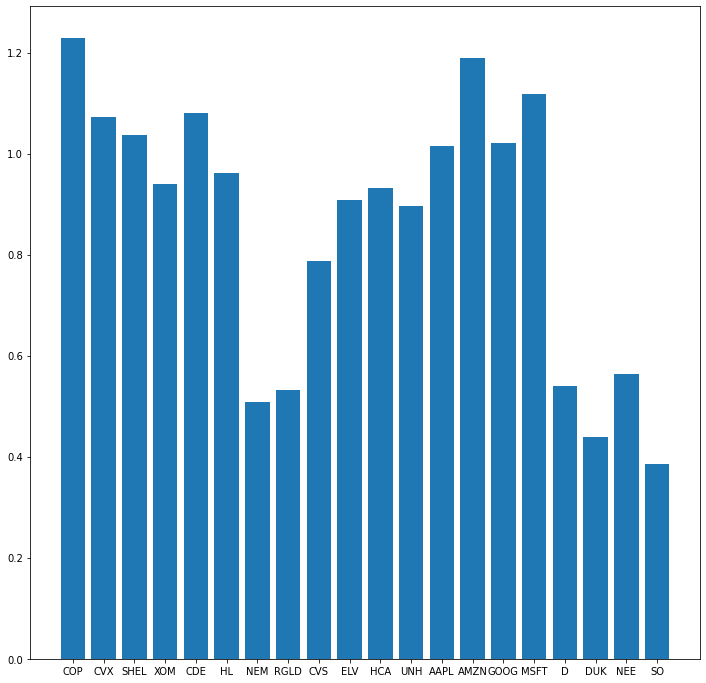

In [8]:
plt.figure(figsize=(12,12))
plt.bar(TRAINING_df2['Ticker'].values, TRAINING_df2['Betas'].values)

Text(0, 0.5, 'WCSS')

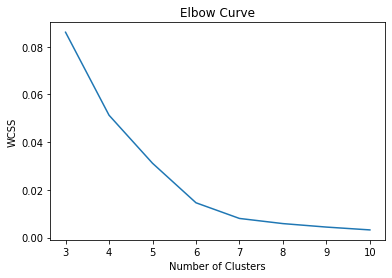

In [9]:
#Use the Elbow method to determine the number of clusters to use to group the stocks based on the beta values
#Note the "intertia" is the Within-cluster Sum of Squares (WCSS)

X = TRAINING_df2['Betas'].values.reshape(-1, 1)

inertia_list = []
for k in range(3,11):
    #Create and train the model
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)

#Plot the data
plt.plot(range(3,11), inertia_list)
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.xticks(range(3,11))
plt.ylabel('WCSS')

In [10]:
#From the elbow method we see that the optimum number of clusters is 7 as this is the point of diminishing returns
#We now get the cluster labels / group for each stock

kmeans = KMeans(n_clusters=7).fit(X)
labels = kmeans.labels_

In [11]:
TRAINING_df2['Group'] = labels

In [12]:
TRAINING_df2

,Ticker,Annual Returns,Annual Variances,Betas,Group
0,COP,0.053882,0.076181,1.229764,4
1,CVX,0.071782,0.042252,1.071533,0
2,SHEL,0.021782,0.050823,1.037784,6
3,XOM,0.054754,0.030664,0.939941,2
4,CDE,-0.002884,0.406178,1.081356,0
5,HL,0.141216,0.307043,0.961650,2
6,NEM,-0.021780,0.163213,0.508015,3
7,RGLD,0.089522,0.188381,0.531687,3
8,CVS,0.160351,0.032281,0.786785,5
9,ELV,0.198703,0.058139,0.907745,2


In [13]:
cluster_dict = {}
for i in TRAINING_df2.index:
    cluster_label = TRAINING_df2['Group'][i]
    ticker = TRAINING_df2['Ticker'][i]
    if cluster_label not in cluster_dict:
        cluster_dict[cluster_label] = set([ticker])
    else:
        cluster_dict[cluster_label].add(ticker)

cluster_dict

{4: {'AMZN', 'COP'},
 0: {'CDE', 'CVX', 'MSFT'},
 6: {'AAPL', 'GOOG', 'SHEL'},
 2: {'ELV', 'HCA', 'HL', 'UNH', 'XOM'},
 3: {'D', 'NEE', 'NEM', 'RGLD'},
 5: {'CVS'},
 1: {'DUK', 'SO'}}

In [14]:
# Create all possible combinations of a portfolio of 8 stocks and select the portolfios that include exactly one stock from each cluster

from itertools import combinations

all_tickers = list(TRAINING_df2['Ticker'])

combs = list(combinations(all_tickers, 7))

#Store only combinations that has exactly one stock per sector in portfolio
portfolios = []

#It is crucial to use set operations to reduce runtime!!
for comb in combs:
    
    comb_set = set(comb)
    
    cluster_count = 0
    
    for cluster in cluster_dict:
        
        if len(set.intersection(comb_set, cluster_dict[cluster])) == 1:
            cluster_count += 1
        else:
            break
    
    if cluster_count == 7:
        portfolios.append(list(comb))


# It is very time consuming to check if every valid portfolio combinations is in our list of 
# portfolios. A great work around for this is to check a couple of values at random indexes in the 
# list and confirm it meets our criteria. Then, check the length of the list of portfolios and make
# sure it matches up with the amount of portfolios expected 
len(portfolios)

720

In [15]:
portfolios[:10]

[['COP', 'CVX', 'SHEL', 'XOM', 'NEM', 'CVS', 'DUK'],
 ['COP', 'CVX', 'SHEL', 'XOM', 'NEM', 'CVS', 'SO'],
 ['COP', 'CVX', 'SHEL', 'XOM', 'RGLD', 'CVS', 'DUK'],
 ['COP', 'CVX', 'SHEL', 'XOM', 'RGLD', 'CVS', 'SO'],
 ['COP', 'CVX', 'SHEL', 'XOM', 'CVS', 'D', 'DUK'],
 ['COP', 'CVX', 'SHEL', 'XOM', 'CVS', 'D', 'SO'],
 ['COP', 'CVX', 'SHEL', 'XOM', 'CVS', 'DUK', 'NEE'],
 ['COP', 'CVX', 'SHEL', 'XOM', 'CVS', 'NEE', 'SO'],
 ['COP', 'CVX', 'SHEL', 'HL', 'NEM', 'CVS', 'DUK'],
 ['COP', 'CVX', 'SHEL', 'HL', 'NEM', 'CVS', 'SO']]

In [16]:
# Expected return and volatility for random portfolio weights
from pylab import mpl, plt

def port_ret(weights, portfolio_df):
    port_rets = np.log(portfolio_df/portfolio_df.shift(1))
    return np.sum(port_rets.mean() * weights) * 252

def port_vol(weights, portfolio_df):
    port_rets = np.log(portfolio_df/portfolio_df.shift(1))
    return np.sqrt(np.dot(weights.T, np.dot(port_rets.cov() * 252, weights)))

In [17]:
# Optimal portfolio
import scipy.optimize as sco

noa = 7

def min_func_sharpe(weights, portfolio_df):
 return -port_ret(weights, portfolio_df) / port_vol(weights, portfolio_df)

# Equality constraint
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for the parameters
bnds = tuple((0, 1) for x in range(noa))

# Starting parameter list
# Equal weights vector
eweights = np.array(noa * [1. / noa,])
eweights

array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
       0.14285714, 0.14285714])

In [18]:
# Optimal portfolio by maximizing the Sharpe Ratio
# Solve for the optimal weights with the maximum sharpe ratio

train_port_sharpe_ratios = {}

for comb in portfolios:
    portfolio_df = TRAINING_df[comb]
    opts = sco.minimize(min_func_sharpe, eweights, args=(portfolio_df), method = 'SLSQP', bounds = bnds, constraints = cons)
    
    sharpe_ratio = -opts['fun']
    
    train_port_sharpe_ratios[tuple(comb)] = sharpe_ratio

In [19]:
#Let's find the top 5 portfolios based on the sharpe ratio based on the training data

train_top_5_SR = sorted(train_port_sharpe_ratios.values(), reverse= True)[:5]

In [20]:
train_top_5_portfolios = []

for i in range(0,5):
    train_top_5_portfolios.append(tuple(list(train_port_sharpe_ratios.keys())[list(train_port_sharpe_ratios.values()).
                                                                              index(train_top_5_SR[i])]))

In [21]:
for portfolio in train_top_5_portfolios:
    sharpe_ratio = train_port_sharpe_ratios[portfolio]
    print(str(portfolio) + " : " + str(sharpe_ratio))

('CVS', 'UNH', 'AAPL', 'AMZN', 'MSFT', 'NEE', 'SO') : 1.549573913288882
('CVS', 'UNH', 'AAPL', 'AMZN', 'MSFT', 'DUK', 'NEE') : 1.549573618770525
('CVS', 'UNH', 'AMZN', 'GOOG', 'MSFT', 'NEE', 'SO') : 1.5469583256601187
('SHEL', 'CVS', 'UNH', 'AMZN', 'MSFT', 'NEE', 'SO') : 1.5469582844458225
('CVS', 'UNH', 'AMZN', 'GOOG', 'MSFT', 'DUK', 'NEE') : 1.5469580824006828


In [22]:
train_port_weight_dict = {}


for portfolio in train_top_5_portfolios:

    portfolio_df = TRAINING_df[list(portfolio)]

    opts = sco.minimize(min_func_sharpe, eweights, args=(portfolio_df), method = 'SLSQP', bounds = bnds, constraints = cons)

    weights = opts['x']
    
    train_port_weight_dict[tuple(portfolio)] = weights

([<matplotlib.patches.Wedge at 0x7ff291a79be0>,
 [Text(1.0924450463634463, 0.12870050767564117, 'CVS'),
  Text(0.38223080079808097, 1.0314550959306266, 'UNH'),
  Text(-0.7338225066007555, 0.8194537990675156, 'AAPL'),
  Text(-1.0625711732406555, 0.2845039574381649, 'AMZN'),
  Text(-1.0019310192954434, -0.4540200794828288, 'MSFT'),
  Text(0.3447307073041182, -1.0445863963510162, 'NEE'),
  Text(1.0999999999999954, -1.0298943298478347e-07, 'SO')])

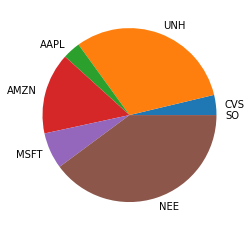

In [23]:
#Let's take a look at the distribution of the portfolio with the highest sharpe ratio in the training dataset
plt.pie(train_port_weight_dict[train_top_5_portfolios[0]], labels = train_top_5_portfolios[0])

Text(0, 0.5, 'values')

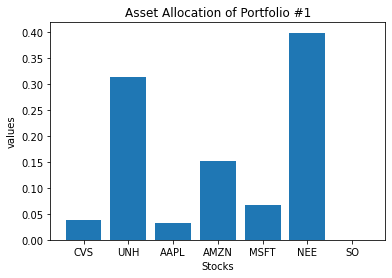

In [24]:
plt.bar(list(train_top_5_portfolios[0]), train_port_weight_dict[train_top_5_portfolios[0]])
plt.title('Asset Allocation of Portfolio #1')
plt.xlabel("Stocks")
plt.ylabel('values')

([<matplotlib.patches.Wedge at 0x7ff2919bdf60>,
 [Text(1.0923749419138924, 0.12929418501471956, 'CVS'),
  Text(0.3818217892069207, 1.0316065729176147, 'UNH'),
  Text(-0.7335540525172217, 0.8196941210204948, 'AAPL'),
  Text(-1.062270006325416, 0.2856263882441551, 'AMZN'),
  Text(-1.002642650315341, -0.45244636783670744, 'MSFT'),
  Text(-0.8848367850447902, -0.6535012347590476, 'DUK'),
  Text(0.3440054281163404, -1.0448254712757024, 'NEE')])

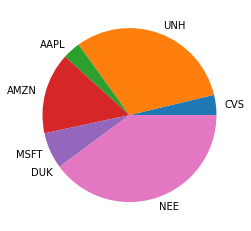

In [25]:
plt.pie(train_port_weight_dict[train_top_5_portfolios[1]], labels = train_top_5_portfolios[1])

Text(0, 0.5, 'values')

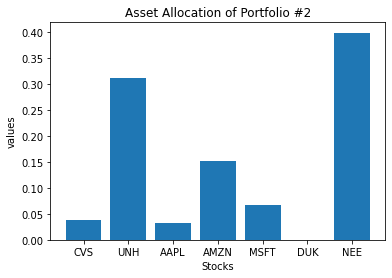

In [26]:
plt.bar(list(train_top_5_portfolios[1]), train_port_weight_dict[train_top_5_portfolios[1]])
plt.title('Asset Allocation of Portfolio #2')
plt.xlabel("Stocks")
plt.ylabel('values')

([<matplotlib.patches.Wedge at 0x7ff2918857f0>,
 [Text(1.0906780503193585, 0.14290343086001503, 'CVS'),
  Text(0.3236617440901387, 1.0513054149068812, 'UNH'),
  Text(-1.0267801699745027, 0.3946168807174011, 'AMZN'),
  Text(-1.091549128414389, -0.13609004466818145, 'GOOG'),
  Text(-1.0278467558945792, -0.39183037962489514, 'MSFT'),
  Text(0.3273730011451989, -1.0501556637571337, 'NEE'),
  Text(1.0999999999999892, 1.5448414929211732e-07, 'SO')])

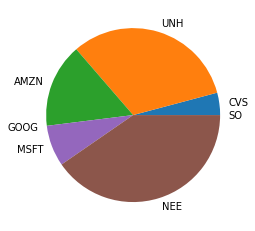

In [27]:
plt.pie(train_port_weight_dict[train_top_5_portfolios[2]], labels = train_top_5_portfolios[2])

Text(0, 0.5, 'values')

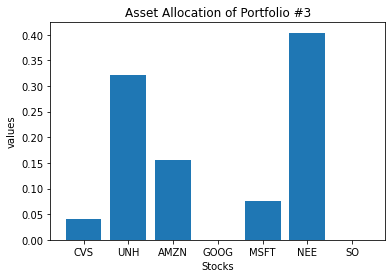

In [28]:
plt.bar(list(train_top_5_portfolios[2]), train_port_weight_dict[train_top_5_portfolios[2]])
plt.title('Asset Allocation of Portfolio #3')
plt.xlabel("Stocks")
plt.ylabel('values')

([<matplotlib.patches.Wedge at 0x7ff2917c1b38>,
 [Text(1.0906780503193585, 0.14290343086001503, 'SHEL'),
  Text(0.3236617440901387, 1.0513054149068812, 'CVS'),
  Text(-1.0267801699745027, 0.3946168807174011, 'UNH'),
  Text(-1.091549128414389, -0.13609004466818145, 'AMZN'),
  Text(-1.0278467558945792, -0.39183037962489514, 'MSFT'),
  Text(0.3273730011451989, -1.0501556637571337, 'NEE'),
  Text(1.0999999999999892, 1.5448414929211732e-07, 'SO')])

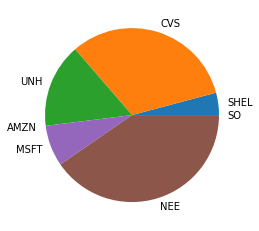

In [29]:
plt.pie(train_port_weight_dict[train_top_5_portfolios[2]], labels = train_top_5_portfolios[3])

Text(0, 0.5, 'values')

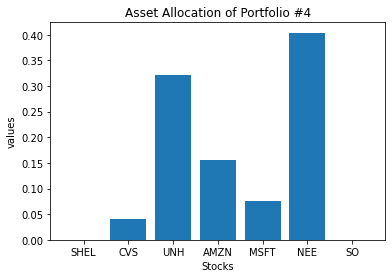

In [30]:
plt.bar(list(train_top_5_portfolios[3]), train_port_weight_dict[train_top_5_portfolios[3]])
plt.title('Asset Allocation of Portfolio #4')
plt.xlabel("Stocks")
plt.ylabel('values')

([<matplotlib.patches.Wedge at 0x7ff29170efd0>,
 [Text(1.0906780503193585, 0.14290343086001503, 'CVS'),
  Text(0.3236617440901387, 1.0513054149068812, 'UNH'),
  Text(-1.0267801699745027, 0.3946168807174011, 'AMZN'),
  Text(-1.091549128414389, -0.13609004466818145, 'GOOG'),
  Text(-1.0278467558945792, -0.39183037962489514, 'MSFT'),
  Text(0.3273730011451989, -1.0501556637571337, 'DUK'),
  Text(1.0999999999999892, 1.5448414929211732e-07, 'NEE')])

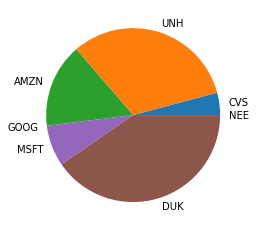

In [31]:
plt.pie(train_port_weight_dict[train_top_5_portfolios[2]], labels = train_top_5_portfolios[4])

Text(0, 0.5, 'values')

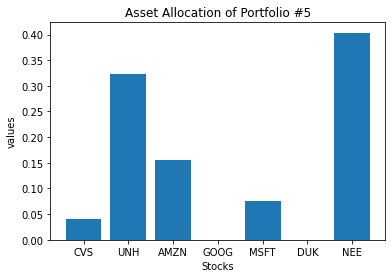

In [32]:
plt.bar(list(train_top_5_portfolios[4]), train_port_weight_dict[train_top_5_portfolios[4]])
plt.title('Asset Allocation of Portfolio #5')
plt.xlabel("Stocks")
plt.ylabel('values')

In [33]:
#Since all the portfolio's are very similar let's focus on the one with the highest sharpe ratio and see how it's distributed

top_port = train_top_5_portfolios[0]

In [34]:
weights = train_port_weight_dict[top_port]
portfolio_df = TRAINING_df[list(top_port)]
TRAINING_port_ret = port_ret(weights, portfolio_df)
TRAINING_port_vol = port_vol(weights, portfolio_df)
print("Portfolio Returns: " + str(TRAINING_port_ret))
print("Portfolio Volatility: " + str(TRAINING_port_vol))

Portfolio Returns: 0.21248279285555638
Portfolio Volatility: 0.13712336729041458


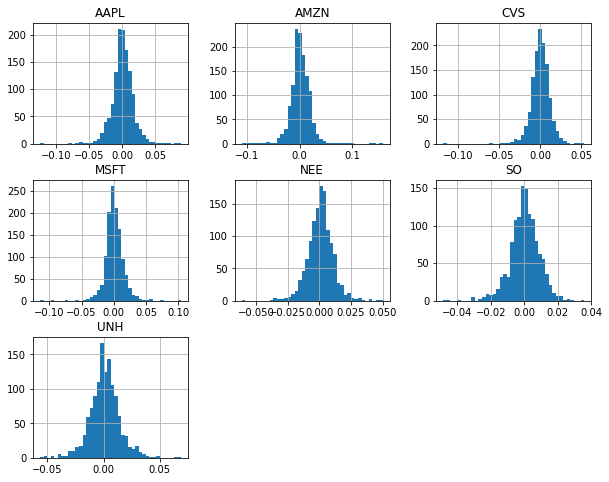

In [35]:
port_rets = daily_returns[list(top_port)]
port_rets.hist(bins = 40, figsize = (10, 8));

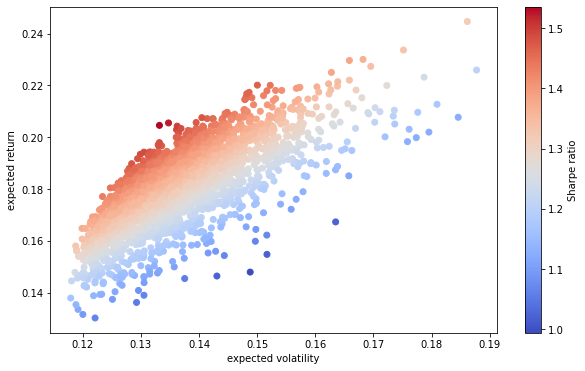

In [36]:
#Lets take a closer look at the portfolio with the highest possible sharpe ratio using Monte Carlo Simulation

def monte_carlo_sim(portfolio):
    
    prets = []
    pvols = []
    
    portfolio_df = TRAINING_df[list(portfolio)]

    # Monte Carlo simulation of portfolio weights
    for p in range (2500):
        weights = np.random.random(noa)
        weights /= np.sum(weights)
        # Collect the resulting returns and volatility in list objects
        prets.append(port_ret(weights, portfolio_df))
        pvols.append(port_vol(weights, portfolio_df))

    prets = np.array(prets)
    pvols = np.array(pvols)

    plt.figure(figsize = (10,6))
    plt.scatter(pvols, prets, c = prets/pvols, marker = 'o', cmap = 'coolwarm')
    plt.xlabel('expected volatility')
    plt.ylabel('expected return')
    plt.colorbar(label = 'Sharpe ratio');


monte_carlo_sim(top_port)

### Now let's see how the portfolios with highest sharpe ratios performed in the PRE-COVID testing dataset

In [37]:
#Let's take a quick look at the returns in the PRE-COVID testing dataset

PRECOVID_rets = PRECOVID_TESTING_df.pct_change().dropna()
PRECOVID_rets.head(10)

,COP,CVX,SHEL,XOM,CDE,HL,NEM,RGLD,CVS,ELV,HCA,UNH,AAPL,AMZN,GOOG,MSFT,D,DUK,NEE,SO
Date,,,,,,,,,,,,,,,,,,,,
2017-01-04,0.009287,-0.000254,0.010141,-0.011002,0.018481,0.012727,0.009529,0.008852,-0.007468,-0.001326,0.035858,0.002849,-0.001119,0.004657,0.000967,-0.004474,-0.000918,-0.001029,0.002948,-0.001019
2017-01-05,-0.002937,-0.004329,0.008785,-0.014907,0.133064,0.046679,0.046053,0.033713,0.020941,0.010626,-0.004149,0.001668,0.005086,0.030732,0.009048,0.000000,0.001313,0.001288,-0.000588,0.003062
2017-01-06,-0.003731,-0.004006,-0.008530,-0.000565,-0.063167,-0.027444,-0.031447,-0.024423,0.009580,-0.001522,-0.002473,0.001418,0.011148,0.019912,0.015277,0.008668,0.008128,-0.003344,-0.002941,-0.002645
2017-01-09,-0.021285,-0.008559,-0.021330,-0.016497,0.004748,-0.001764,-0.001694,0.005190,-0.006083,-0.010807,0.030018,-0.002833,0.009159,0.001168,0.000620,-0.003183,-0.015345,-0.010969,-0.002529,-0.009794
2017-01-10,0.000000,-0.007597,-0.004213,-0.012753,0.036862,0.028269,-0.007919,0.017312,0.011873,0.024862,-0.008236,-0.002284,0.001009,-0.001280,-0.002306,-0.000319,-0.003830,-0.001827,0.001943,-0.003091
2017-01-11,0.031413,0.008438,0.020232,0.010241,-0.000912,-0.005155,-0.020240,-0.004777,0.001210,-0.003485,0.013287,0.001919,0.005373,0.003920,0.003877,0.009103,0.002651,0.007843,0.007000,0.007441
2017-01-12,-0.020890,0.001984,0.004327,-0.005414,-0.006387,0.003454,0.002910,-0.001500,-0.002054,0.016183,-0.002396,0.002903,-0.004175,0.018297,-0.001919,-0.009179,-0.004628,0.005707,0.000754,0.005334
2017-01-13,0.008774,0.001894,-0.004129,0.000116,0.045914,0.027539,0.001740,0.009163,-0.007506,0.002294,0.003539,-0.003449,-0.001761,0.004302,0.001885,0.001438,-0.000930,-0.004256,-0.003765,-0.004082
2017-01-17,-0.008697,-0.000859,0.001082,0.011697,0.018437,0.020101,0.017666,0.017862,0.023664,-0.011984,0.019270,-0.007046,0.008065,-0.009080,-0.004048,-0.002711,0.013163,0.003238,0.009828,0.018238


In [38]:
#Now let's take a look at how the top portfolios found using the training dataset performed in the PRE-COVID testing dataset

for portfolio in train_top_5_portfolios:
    
    weights = train_port_weight_dict[portfolio]
    portfolio_df = PRECOVID_TESTING_df[list(portfolio)]
    sharpe_ratio = -min_func_sharpe(weights, portfolio_df)
    
    print(str(portfolio) + " : " + str(sharpe_ratio))

('CVS', 'UNH', 'AAPL', 'AMZN', 'MSFT', 'NEE', 'SO') : 1.927663382902878
('CVS', 'UNH', 'AAPL', 'AMZN', 'MSFT', 'DUK', 'NEE') : 1.927857134817072
('CVS', 'UNH', 'AMZN', 'GOOG', 'MSFT', 'NEE', 'SO') : 1.8993387983903505
('SHEL', 'CVS', 'UNH', 'AMZN', 'MSFT', 'NEE', 'SO') : 1.8995667892847548
('CVS', 'UNH', 'AMZN', 'GOOG', 'MSFT', 'DUK', 'NEE') : 1.8989248528103253


In [39]:
#Now let's take a look closer at how the top portfolio in the training dataset performed

weights = train_port_weight_dict[top_port]
portfolio_df = PRECOVID_TESTING_df[list(top_port)]
PRECOVID_port_ret = port_ret(weights, portfolio_df)
PRECOVID_port_vol = port_vol(weights, portfolio_df)
print("Portfolio Returns: " + str(PRECOVID_port_ret))
print("Portfolio Volatility: " + str(PRECOVID_port_vol))

Portfolio Returns: 0.2512289234629903
Portfolio Volatility: 0.13032821274255021


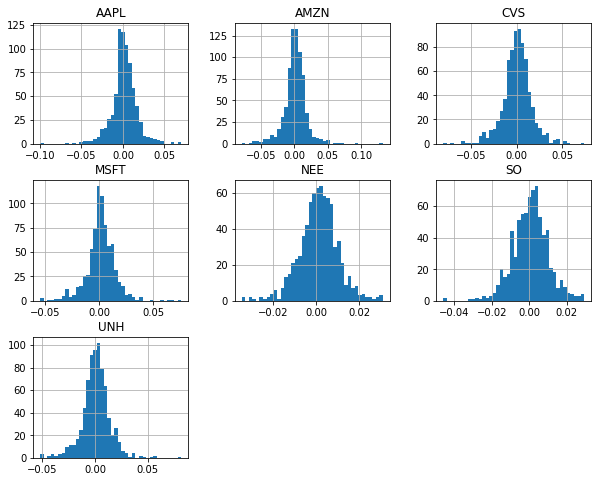

In [40]:
port_rets = PRECOVID_rets[list(top_port)]
port_rets.hist(bins = 40, figsize = (10, 8));

### Now let's see how the portfolios with highest sharpe ratios performed in the COVID testing dataset 

In [41]:
#Let's take a quick look at the returns in the COVID testing dataset

COVID_rets = COVID_TESTING_df.pct_change().dropna()
COVID_rets.head(10)

,COP,CVX,SHEL,XOM,CDE,HL,NEM,RGLD,CVS,ELV,HCA,UNH,AAPL,AMZN,GOOG,MSFT,D,DUK,NEE,SO
Date,,,,,,,,,,,,,,,,,,,,
2020-01-03,0.003666,-0.003459,0.007867,-0.008040,-0.014085,-0.020468,-0.009024,-0.008174,-0.007956,-0.013261,0.003051,-0.010120,-0.009722,-0.012139,-0.004907,-0.012452,-0.002440,0.000664,0.007124,-0.000958
2020-01-06,0.011872,-0.003388,0.012456,0.007678,-0.100000,-0.011940,0.010040,-0.010988,0.003942,0.012025,0.003785,0.006942,0.007969,0.014886,0.024657,0.002585,0.007706,0.004867,0.004993,0.003996
2020-01-07,0.000000,-0.012770,-0.009186,-0.008184,-0.005772,0.030211,-0.000694,0.011531,-0.003791,-0.003029,-0.001347,-0.006037,-0.004703,0.002092,-0.000624,-0.009118,-0.002185,-0.006275,-0.000870,-0.003025
2020-01-08,-0.023165,-0.011423,-0.011755,-0.015080,-0.087083,-0.043988,-0.026602,-0.071393,-0.012503,0.026507,0.006608,0.021084,0.016086,-0.007809,0.007880,0.015929,-0.006325,0.001440,-0.000456,-0.000320
2020-01-09,0.017400,-0.001614,-0.000168,0.007656,0.017488,-0.058282,-0.009981,0.005287,0.002752,-0.003480,-0.012460,-0.005678,0.021241,0.004799,0.011044,0.012493,0.002816,0.002434,0.007836,0.010543
2020-01-10,-0.009838,-0.009106,-0.011227,-0.008888,0.023438,0.003257,0.014642,0.014262,-0.010294,0.004341,0.004884,0.003093,0.002261,-0.009411,0.006973,-0.004627,0.001831,-0.001986,0.001892,0.006323
2020-01-13,-0.004433,0.001889,-0.000847,0.009546,-0.018321,-0.009740,0.004258,-0.022937,0.009014,-0.035745,-0.006615,-0.031444,0.021364,0.004323,0.006645,0.012025,-0.000244,0.008845,0.011702,0.013823
2020-01-14,0.000154,-0.003086,-0.000678,-0.008596,0.024883,0.029508,0.008952,0.010703,0.014706,0.000472,0.005096,0.008361,-0.013503,-0.011558,-0.005802,-0.007043,-0.001219,0.000658,0.005398,0.005888
2020-01-15,-0.002149,-0.001462,-0.001697,-0.001590,0.056146,0.031847,0.016110,0.019845,0.019504,0.015730,-0.004462,0.028345,-0.004285,-0.003969,0.005815,0.006476,0.012691,0.013034,0.015541,0.010166


In [42]:
#Now let's take a look at how the top portfolios found using the training dataset performed in the COVID testing dataset

for portfolio in train_top_5_portfolios:
    
    weights = train_port_weight_dict[portfolio]
    portfolio_df = COVID_TESTING_df[list(portfolio)]
    sharpe_ratio = -min_func_sharpe(weights, portfolio_df)
    
    print(str(portfolio) + " : " + str(sharpe_ratio))

('CVS', 'UNH', 'AAPL', 'AMZN', 'MSFT', 'NEE', 'SO') : 0.9943844820853028
('CVS', 'UNH', 'AAPL', 'AMZN', 'MSFT', 'DUK', 'NEE') : 0.9943122412682911
('CVS', 'UNH', 'AMZN', 'GOOG', 'MSFT', 'NEE', 'SO') : 0.9775785824135252
('SHEL', 'CVS', 'UNH', 'AMZN', 'MSFT', 'NEE', 'SO') : 0.977593949164001
('CVS', 'UNH', 'AMZN', 'GOOG', 'MSFT', 'DUK', 'NEE') : 0.9776229348307766


In [43]:
#Now let's take a look closer at how the top portfolio in the training dataset performed

weights = train_port_weight_dict[top_port]
portfolio_df = COVID_TESTING_df[list(top_port)]
COVID_port_ret = port_ret(weights, portfolio_df)
COVID_port_vol = port_vol(weights, portfolio_df)
print("Portfolio Returns: " + str(COVID_port_ret))
print("Portfolio Volatility: " + str(COVID_port_vol))

Portfolio Returns: 0.2761959038778191
Portfolio Volatility: 0.27775564568205496


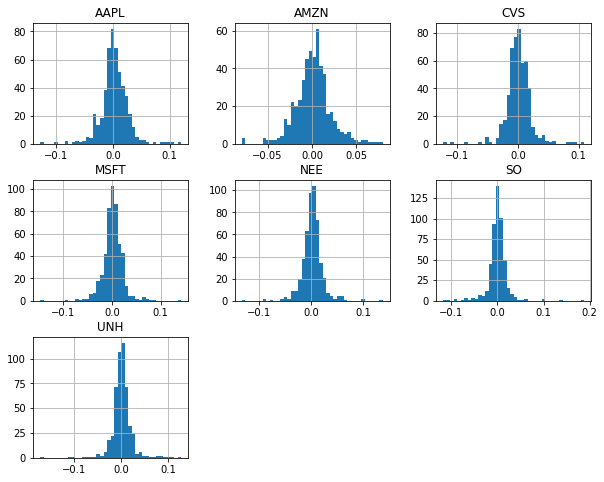

In [44]:
port_rets = COVID_rets[list(top_port)]
port_rets.hist(bins = 40, figsize = (10, 8));